In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib
import os
import copy
from scipy.optimize import minimize

from icedef import constants, iceberg, metocean, drift, tools
from icedef import statoil_data_2015 as statoil_data

# Acquire Beacon Data 

In [2]:
df = statoil_data.get_df(statoil_data.dir_path, statoil_data.csv_filenames[2])

# Simulate

In [3]:
start_index = 1100
end_index = 1120

ref_berg = statoil_data.create_ref_berg_from_df(df, start_index, end_index)

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

meto = metocean.Metocean((start_time, end_time))

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = statoil_data.get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)

In [4]:
def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    forces_mat = []
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time - time_step:
        
        berg.update_history()

        ax, ay, forces = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))
        
        #print(current_velocity)
        
        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
        
        forces_mat.append(forces)
        
    forces_mat = np.array(forces_mat)
            
    return berg, forces_mat

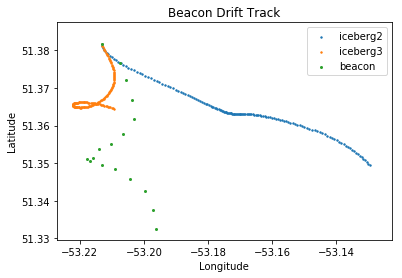

In [5]:
berg2, forces_mat2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)

berg3, forces_mat3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=0.1, Cw=5)

plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

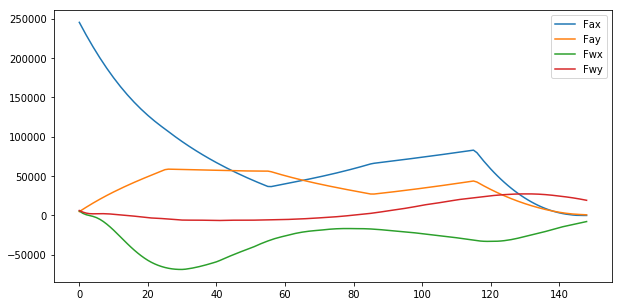

In [6]:
fig = plt.figure(figsize=(10, 5))

plt.plot(forces_mat2[:, 0], label='Fax')
plt.plot(forces_mat2[:, 1], label='Fay')
plt.plot(forces_mat2[:, 2], label='Fwx')
plt.plot(forces_mat2[:, 3], label='Fwy')

plt.legend()
plt.show()


# Optimization

In [16]:
def optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    
    berg, forces_mat = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    try:
        mse = tools.compute_mse((berg.longitude, berg.latitude, berg.time),
                           (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time']),
                           ref_berg.history['time'][0] - np.timedelta64(1,'D'))
    except:
        print(berg2.time)
        raise
    
    return mse


def optimization_wrapper2(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    obs_vecs = (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time'])
    reference_time = ref_berg.history['time'][0] - np.timedelta64(1,'D')
    
    berg, forces_mat = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    mse_list = []
    
    for i in range(len(ref_berg.history['time']) - 1):
        
        j = np.where((berg.history['time'] <= ref_berg.history['time'][i + 1]))[0][-1]
        sim_point = (berg.history['longitude'][j], berg.history['latitude'][j], berg.history['time'][j])
        mse = tools.compute_mse(sim_point, obs_vecs, reference_time)
        mse_list.append(mse)
    
    mse = np.mean(np.array(mse_list))
    
    return mse



callback_mses = []
callback_Cas = []
callback_Cws = []

def callback(x):
    
    result = optimization_wrapper(x, ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info)
    callback_mses.append(result)
    callback_Cas.append(x[0])
    callback_Cws.append(x[1])

In [10]:
optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 15), (0, 15)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.02677430158645897
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.15896223e-06, -4.70640887e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 66
      nit: 9
   status: 0
  success: True
        x: array([ 0.94699108, 15.        ])

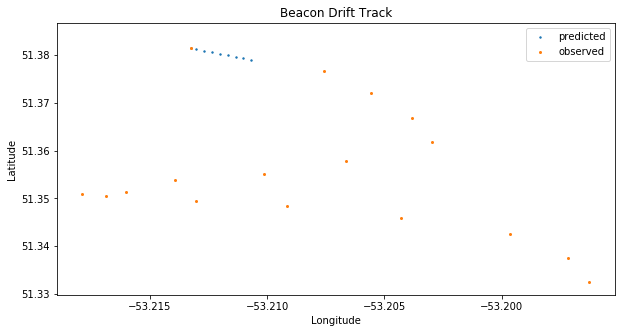

In [17]:
fig = plt.figure(figsize=(10, 5))

berg, forces_mat = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), meto, time_info, 
                                 Ca=optimization_result.x[0], Cw=optimization_result.x[1])

plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2, label='predicted')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='observed')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

## Over progressively longer time scales

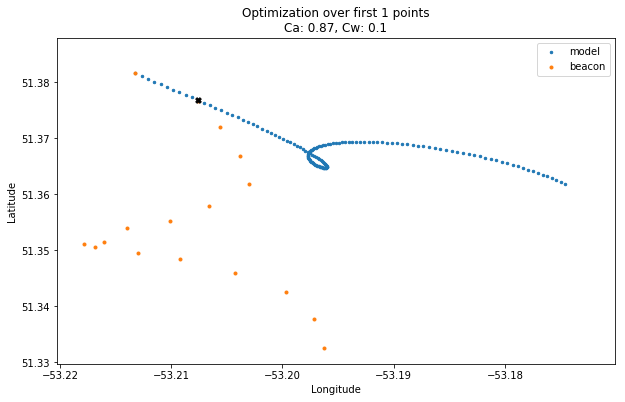

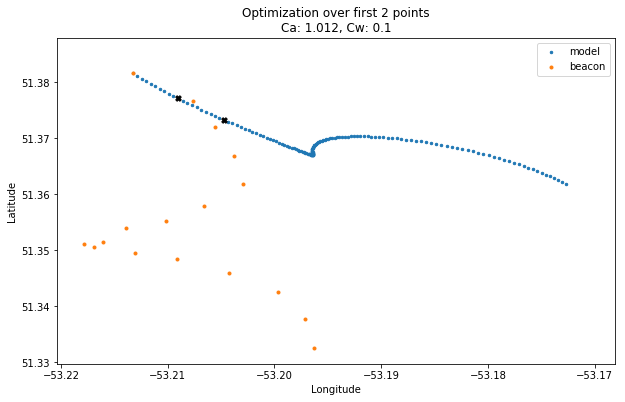

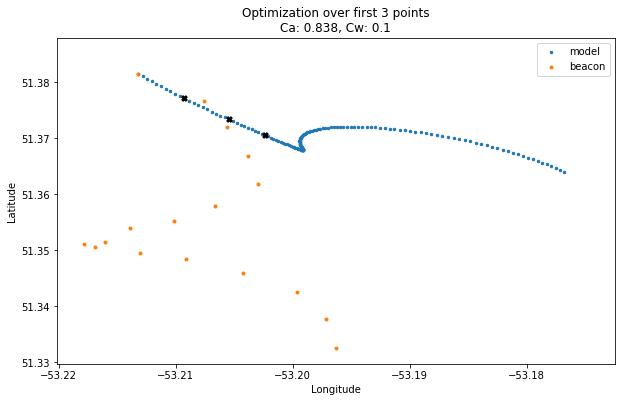

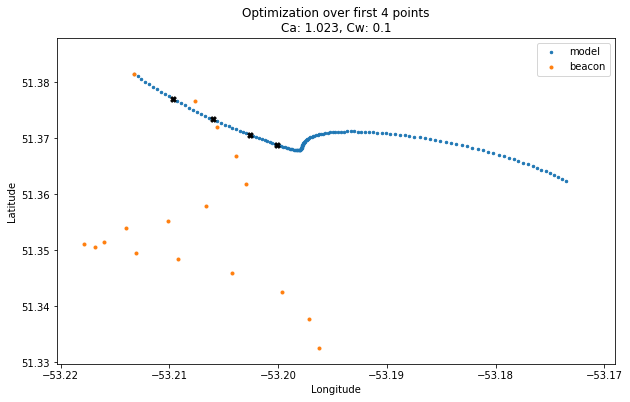

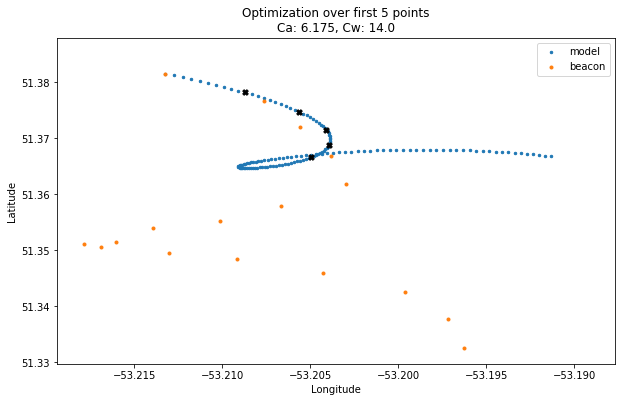

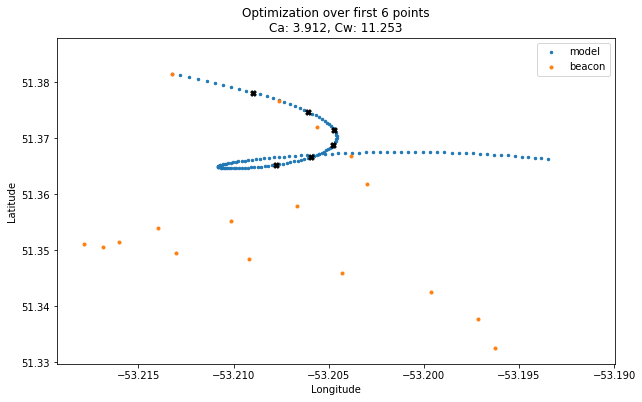

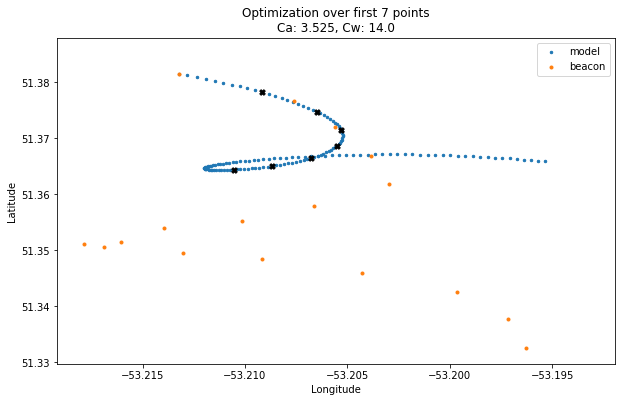

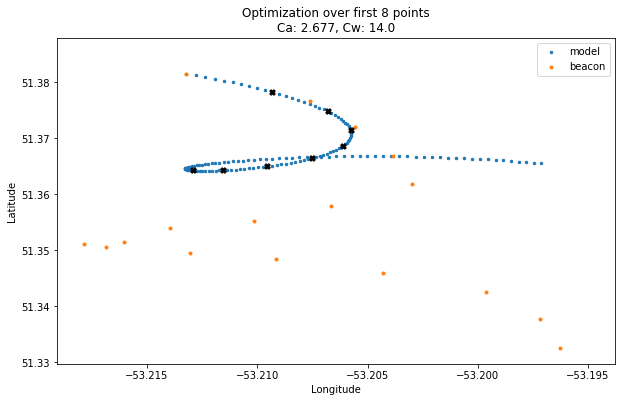

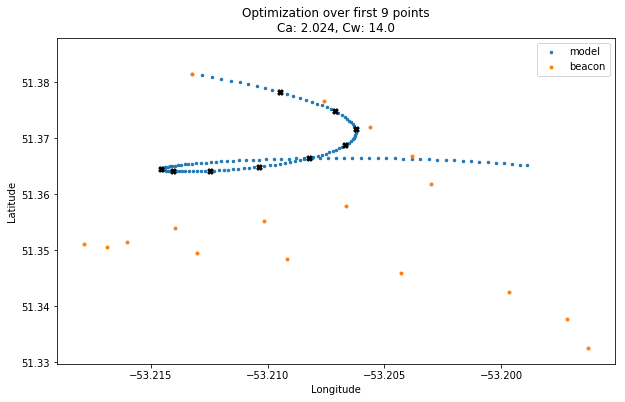

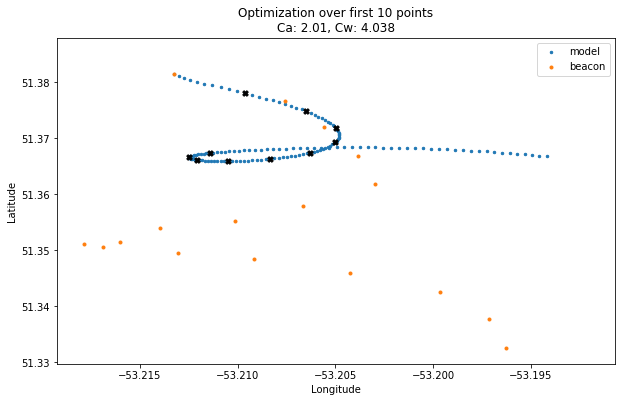

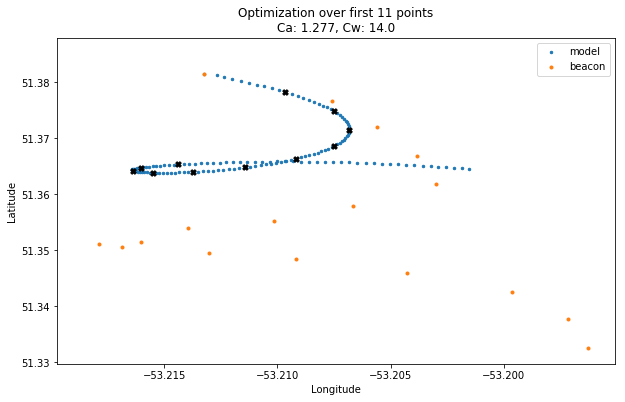

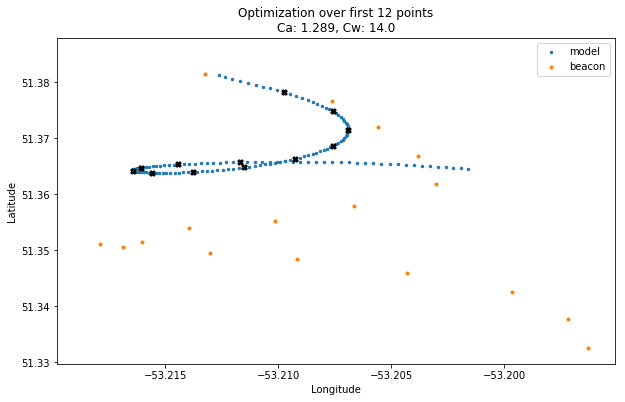

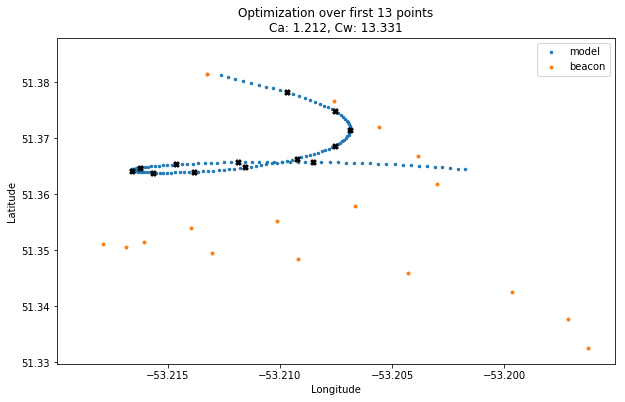

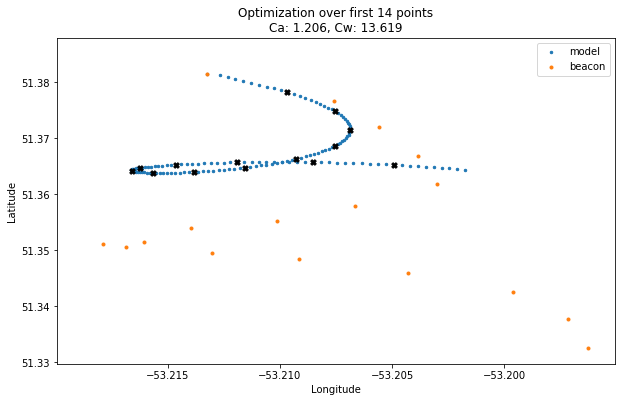

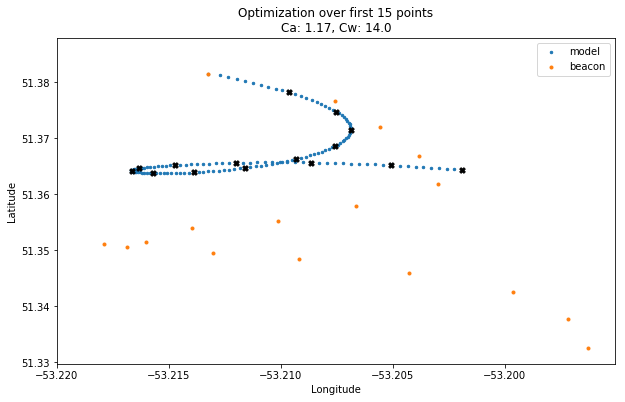

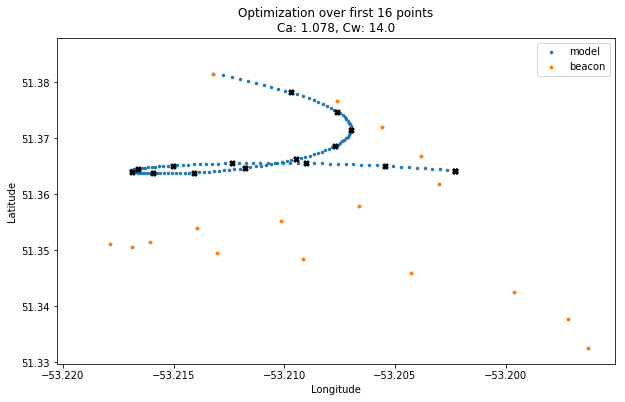

In [26]:
with PdfPages('plots/optim_steps.pdf') as pdf:

    for indxf in range(1, len(ref_berg.history['time'])):

        indxi = 0
        indxf = indxf

        sub_ref_berg = copy.deepcopy(ref_berg)
        sub_ref_berg.history['time'] = sub_ref_berg.history['time'][indxi : indxf + 1]
        sub_ref_berg.history['latitude'] = sub_ref_berg.history['latitude'][indxi : indxf + 1]
        sub_ref_berg.history['longitude'] = sub_ref_berg.history['longitude'][indxi : indxf + 1]

        start_time = sub_ref_berg.history['time'][indxi]
        end_time = sub_ref_berg.history['time'][indxf]
        start_latitude = sub_ref_berg.history['latitude'][indxi]
        start_longitude = sub_ref_berg.history['longitude'][indxi]
        start_velocity = statoil_data.get_iceberg_velocity_from_dataframe(df, start_index + indxi - 1, 
                                                                          start_index + indxf + 1)
        time_step = np.timedelta64(360, 's')
        time_info = (time_step, end_time)


        optimization_result = minimize(optimization_wrapper2, x0=(1, 1), bounds=((0.1, 14), (0.1, 14)), 
                                       args=(sub_ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                             meto, time_info))#, callback=callback)

        end_time = np.datetime64(df.DataDate_UTC[end_index])
        time_info = (time_step, np.datetime64(df.DataDate_UTC[end_index]))  # end of ref_berg time

        berg, forces_mat = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                              meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

        berg.update_history()

        fig = plt.figure(figsize=(10, 6))

        plt.scatter(berg.history['longitude'], berg.history['latitude'], s=6, label='model')
        plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=9, label='beacon')

        for k, ktime in enumerate(ref_berg.history['time'][:indxf+1]):

            if not k == 0:
                kberg = np.argmin(abs(berg.history['time'] - ktime))
                plt.scatter(berg.history['longitude'][kberg], berg.history['latitude'][kberg], 
                            s=30, marker='X', c='black')

        plt.legend()
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        rounded_Ca = round(optimization_result.x[0], 3) 
        rounded_Cw = round(optimization_result.x[1], 3)
        plt.title(f'Optimization over first {indxf} points\n' + \
                 f'Ca: {rounded_Ca}, Cw: {rounded_Cw}')
        plt.show()
            
        pdf.savefig(fig)